In [ ]:
# default_exp pde

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
import numpy as np
from nangs.bocos import *
import matplotlib.pyplot as plt
import math

# PDE

> This module contains the PDE class with the basic functionality to solve PDEs with NNs.

In [ ]:
#export

from nangs.utils import *
import torch
from torch.utils.data import Dataset, DataLoader
from fastprogress import master_bar, progress_bar
import numpy as np

class PDEDataset(Dataset):
    "Receives a dict of arrays and returns every possible combination of the elements in the arrays"
    def __init__(self, inputs):
        # convert dict to array
        self.inputs = np.array([inputs[k] for k in inputs])
        # length of the dataset (all possible combinations)
        self.len = 1
        for input in self.inputs:
            self.len *= len(input)
        # modules
        self.mods = []
        for i, _ in enumerate(self.inputs):
            mod = 1
            for j, input in enumerate(self.inputs):
                if j < i:
                    mod *= len(input)
            self.mods.append(mod)  
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return torch.FloatTensor([inp[(idx // self.mods[i]) % len(inp)] for i, inp in enumerate(self.inputs)])

class PDE:
    "PDE class with basic functionality to solve PDEs with NNs"
    def __init__(self, inputs, outputs, params=None, order=1):
        
        # check lists of unique strings, non-repeated
        checkIsListOfStr(inputs)
        checkUnique(inputs)
        checkIsListOfStr(outputs)
        checkUnique(outputs)
        checkNoRepeated(inputs, outputs)
        if params:
            checkIsListOfStr(params)
            checkUnique(params)
            checkNoRepeated(inputs, params)
            checkNoRepeated(params, outputs)
        
        # save keys
        self.input_keys = inputs
        self.output_keys = outputs
        self.param_keys = params            
        
        # initialize values
        self.train_inputs = {k: [] for k in self.input_keys}
        self.test_inputs = {k: [] for k in self.input_keys}
        self.outputs = {k: [] for k in self.output_keys}
        self.params = {}
        if self.param_keys:
            self.params = {k: [] for k in self.param_keys}
        
        # bocos
        self.bocos = []
        
        self.n_inputs = len(self.input_keys)
        self.n_outputs = len(self.output_keys)
        self.order = order
        self.eval = False

    def summary(self):
        "Print a summary of the PDE inputs, outputs, params and bocos."
        print('inputs (train): ', self.train_inputs)
        print('inputs (test): ', self.test_inputs)
        print('outputs: ', self.outputs)
        if self.params:
            print('params: ', self.params)
        print('bocos: ', [boco.type for boco in self.bocos])
        print('')
        
    def setValues(self, values, train=True):
        self.eval = not train
        "Set values for inputs and params"
        checkValidDict(values)
        for key in values:
            value = values[key]
            if key in self.input_keys: 
                if train: 
                    self.train_inputs[key] = value
                else: 
                    self.test_inputs[key] = value
            elif key in self.param_keys: 
                if train:    
                    self.params[key] = value
                else: 
                    raise Exception('You cannot set params in test data !')
            elif key in self.output_keys:
                raise Exception('You cannot set values to outputs !')
            else:
                raise Exception('Key '+ key +' not found !')
                
    def addBoco(self, boco):
        "Add a boco to the list of bocos"
        boco.addBoco(self.input_keys, self.output_keys)
        self.bocos += [boco]
        
    def bocoSummary(self):
        "Print summary of each boco"
        for boco in self.bocos: 
            boco.summary(self.input_keys, self.output_keys, self.param_keys) 
            
    def compile(self, model, optimizer):
        self.solution = model
        self.optimizer = optimizer
        
    def solve(self, epochs=30, batch_size=32, device="cuda", path="best.pth"):
        "Find a solution to the PDE"
        # initialize dataloaders
        self.initialize(batch_size)
        # convert params to tensors
        params = {k: torch.FloatTensor(self.params[k]).to(device) for k in self.params}
        # train loop
        self.solution.to(device)
        best_loss = 1e8
        hist = {'train_loss': [], 'bocos': {boco.name: [] for boco in self.bocos}}
        if self.eval:
            hist['val_loss'] = []
        mb = master_bar(range(1, epochs+1))
        for epoch in mb:
            #train
            self.solution.train()
            pdes_losses = []
            bocos_loss = {boco.name: [] for boco in self.bocos}
            for inputs in progress_bar(self.dataloader['train'], parent=mb):
                                    
                # start accumulating gradients                
                self.optimizer.zero_grad()

                # accumulate gradients for each boco
                for boco in self.bocos:
                    boco_loss = boco.computeLoss(self.solution, device)
                    bocos_loss[boco.name].append(boco_loss.item())
                    boco_loss.backward()
                    
                # accumulate gradients for each pde
                inputs = inputs.to(device)
                inputs.requires_grad = True
                outputs = self.solution(inputs)
                
                # compute gradients of outputs w.r.t. inputs
                grads, _inputs, _outputs = self.computeGrads(inputs, outputs)
                
                # compute loss
                loss = self.computePDELoss(grads, _inputs, _outputs, params)
                pde_loss = []
                for l in loss:
                    l = l.pow(2).mean()
                    l.backward(retain_graph=True)
                    pde_loss.append(l.item())                  
                
                # update weights
                self.optimizer.step()
                
                mb.child.comment = f'train loss {np.mean(pdes_losses):.5f}'
                pdes_losses.append(pde_loss)                    
            
            pde_total_loss = np.mean(pdes_losses, axis=0)
            bocos_total_loss = 0
            for boco in self.bocos:
                bocos_loss[boco.name] = np.mean(bocos_loss[boco.name])
                hist['bocos'][boco.name].append(bocos_loss[boco.name])
                bocos_total_loss += bocos_loss[boco.name]
            total_loss = np.mean(pde_total_loss) + bocos_total_loss
            
            hist['train_loss'].append(total_loss)
            info = f'Epoch {epoch}/{epochs} Losses {total_loss:.5f} \n PDE  [ '
            for l in pde_total_loss:
                info += f"{l:.5f} "
            info += "] "
            for boco in self.bocos:
                info += f'\n {boco.name} {bocos_loss[boco.name]:.5f}'
                
            if self.eval:
                #evaluate
                self.solution.eval()
                val_losses = []
                for inputs in progress_bar(self.dataloader['val'], parent=mb):
                    # compute pde solution
                    inputs = inputs.to(device)
                    inputs.requires_grad = True
                    outputs = self.solution(inputs)
                    # compute gradients of outputs w.r.t. inputs
                    grads, _inputs, _outputs = self.computeGrads(inputs, outputs)
                    # compute loss
                    loss = self.computePDELoss(grads, _inputs, _outputs, params)
                    #loss can be a single value (one pde) or a list (system of pdes)
                    if type(loss) != list:
                        loss = [loss]
                    val_loss = []
                    for l in loss:
                        l = l.pow(2).mean()                 
                        val_loss.append(l.item())
                    val_losses.append(val_loss)
                    mb.child.comment = f'val loss {np.mean(val_losses):.5f}'
                
                # save model if best loss (this does not include bocos losses !!!)
                val_total_loss = np.mean(val_losses)
                if val_total_loss < best_loss:
                    best_loss = total_loss
                    torch.save(self.solution.state_dict(), path)
            
                hist['val_loss'].append(val_total_loss)
                info += '\n Val [ '
                for l in np.mean(val_losses, axis=0):
                    info += f"{l:.5f} "
                info += ']'
                
            mb.write(info)          
            #mb.first_bar.comment = f'best acc {best_acc:.5f} at epoch {best_e}'
            
        return hist
                
    def warm(self, epochs=30, batch_size=32, device="cuda", bocos=None):
        # initialize dataloaders
        self.initialize(batch_size, only_bocos=True)
        # train loop
        self.solution.to(device)
        self.solution.train()  
        # keep some bocos to warm (all by default)
        boco_names = [boco.name for boco in self.bocos]
        if bocos:
            for boco in bocos:
                if boco not in boco_names:
                    raise Exception (f"Boco {boco} not found")
            self.warm_bocos = [boco for boco in self.bocos if boco.name in bocos]
        else:
            self.warm_bocos = self.bocos
        hist = {boco.name: [] for boco in self.warm_bocos}
        # train
        for epoch in progress_bar(range(1, epochs+1)):
            # start accumulating gradients                
            self.optimizer.zero_grad()                
            bocos_loss = {boco.name: [] for boco in self.bocos}
            for boco in self.warm_bocos:                
                # accumulate gradients for each boco
                boco_loss = boco.computeLoss(self.solution, device)
                bocos_loss[boco.name].append(boco_loss.item())
                boco_loss.backward()
            # update weights
            self.optimizer.step()             
            # visualize losses
            for boco in self.warm_bocos:
                bocos_loss[boco.name] = np.mean(bocos_loss[boco.name])
                hist[boco.name].append(bocos_loss[boco.name])                    
        return hist
    
    def initialize(self, bs, only_bocos=False):
        for boco in self.bocos:
            boco.initialize(bs)
        if not only_bocos:
            self.dataset = {
            'train': PDEDataset(self.train_inputs),
            'val': PDEDataset(self.test_inputs)
            } 
            self.dataloader = {
                'train': DataLoader(self.dataset['train'], batch_size=bs, shuffle=True),
                'val': DataLoader(self.dataset['val'], batch_size=bs, shuffle=False)
            }

    def computeGrads(self, inputs, outputs):
        # init grads
        grads = {o: {i: [] for i in self.input_keys} for o in self.output_keys}    
        
        # save inputs for grads
        self.inputs = inputs
        
        # compute first order derivatives 
        for i, output in enumerate(self.output_keys):            
            _grads = self.computeGrad(outputs[:,i])            
            #print(_grads)
            # save in dict
            for j, inp in enumerate(self.input_keys):
                grads[output][inp] = _grads[:,j]                 
            
            # compute higher order derivatives (only works for second order)
            if self.order > 1:                                  
                #order = 1
                #while order < self.order:
                #order += 1 
                
                order = 2
                grads[f'{order}{output}'] = {}
                # compute gradients of gradients
                for j, inp in enumerate(self.input_keys):
                    __grads = self.computeGrad(_grads[:,j])
                    # save in dict
                    for k, inp2 in enumerate(self.input_keys):
                        grads[f'{order}{output}'][f'{inp}{inp2}'] = __grads[:,k]
        
        # assign keys to inputs
        # DOING THIS BREAKS GRADIENTS
        _inputs = {inp: inputs[:,i] for i, inp in enumerate(self.input_keys)}
        
        # assign keys to outputs
        _outputs = {o: outputs[:,i] for i, o in enumerate(self.output_keys)}
        
        return grads, _inputs, _outputs
    
    def computeGrad(self, outputs, input_key=None):
        # torch.autograd.grad -> Computes and returns the sum of gradients of outputs w.r.t. the inputs.
        _grads, = torch.autograd.grad(outputs, self.inputs, 
                        grad_outputs=outputs.data.new(outputs.shape).fill_(1),
                        create_graph=True, only_inputs=True)
        if input_key:
            k = self.input_keys.index(input_key)
            return _grads[:,k]
        return _grads
                        
    def computePDELoss(self, grads, inputs, outputs, params):
        print('This function has to be overloaded by a child class!')
        
    def load_state_dict(self, path):
        self.solution.load_state_dict(torch.load(path))
        
    def evaluate(self, inputs, device="cuda"):
        "Evaluate solution"
        checkValidDict(inputs)
        checkDictArray(inputs, self.input_keys)
        # set values of inpenedent vars 
        for key in self.input_keys: 
            if key in inputs: 
                self.test_inputs[key] = inputs[key] 
            else: 
                raise Exception(key + ' is not an input')
        # build dataset
        dataset = PDEDataset(self.test_inputs)
        outputs = []
        self.solution.to(device)
        self.solution.eval()
        for i in range(len(dataset)):
            input = dataset[i].to(device).unsqueeze(0)
            outputs.append(self.solution(input).cpu().detach().numpy()[0])
        outputs = np.array(outputs)
        for i, k in enumerate(self.output_keys):
            self.outputs[k] = outputs[:,i]

## Instantiate a PDE

In [ ]:
pde = PDE(inputs=['x', 't'], outputs=['p'], params=['u'])

*inputs*, *outputs* and *params* must be lists of strings with non-repeated elements or you will get an error.

In [ ]:
try:
    pde = PDE(inputs=['x', 't'], outputs=['x'], params=['u'])
except Exception as e:
    assert str(e) == "Repeated item x", "assertion failed"

In [ ]:
#hide

pde = PDE(['a'], ['b'])
pde = PDE(inputs=['a'], outputs=['b'])
pde = PDE(inputs=['a', 'b', 'c'], outputs=['d'])
pde = PDE(inputs=['a'], outputs=['b', 'c', 'd'])
pde = PDE(inputs=['a'], outputs=['b'], params=['c'])
pde = PDE(inputs=['a', 'b'], outputs=['c'], params=['d', 'e', 'f'])

try:
    pde = PDE(inputs=['a'])
except Exception as e:
    assert str(e) == "__init__() missing 1 required positional argument: 'outputs'", "assertion failed"
    
try:
    pde = PDE(outputs=['a'])
except Exception as e:
    assert str(e) == "__init__() missing 1 required positional argument: 'inputs'", "assertion failed"
    
try:
    pde = PDE(inputs=['a'], outputs=42)
except Exception as e:
    assert str(e) == "42 must be a list of strings", "assertion failed"
    
try:
    pde = PDE(inputs=None, outputs=42)
except Exception as e:
    assert str(e) == "None must be a list of strings", "assertion failed"
    
try:
    pde = PDE(inputs=['a', 42], outputs=['b'])
except Exception as e:
    assert str(e) == "42 must be a string", "assertion failed"
    
try:
    pde = PDE(inputs=['a', 'b'], outputs=['b'])
except Exception as e:
    assert str(e) == "Repeated item b", "assertion failed"
    
try:
    pde = PDE(inputs=['a', 'b'], outputs=['c'], params=['a'])
except Exception as e:
    assert str(e) == "Repeated item a", "assertion failed"

## Print a summary

Get a summary of the PDE inputs, outputs, params and bocos.

In [ ]:
pde = PDE(inputs=['x', 't'], outputs=['p'], params=['u'])

pde.summary()

inputs (train):  {'x': [], 't': []}
inputs (test):  {'x': [], 't': []}
outputs:  {'p': []}
params:  {'u': []}
bocos:  []



## Setting values

To solve a PDE you must set some input values, and optionally free-parameters. You cannot set output values (this will be given by the neural network).

In [ ]:
pde = PDE(inputs=['a', 'b'], outputs=['c'], params=['d'])

a = np.array([0, 0.5, 1])
b = np.array([0, 0.5, 1])
d = np.array([1.0])
pde.setValues({'a': a, 'b': b, 'd': d})

try:
    pde.setValues({'a': a, 'b': b, 'c': d})
except Exception as e:
    assert str(e) == "You cannot set values to outputs !", "assertion failed"
    
try:
    pde.setValues({'a': a, 'b': b, 'e': d})
except Exception as e:
    assert str(e) == "Key e not found !", "assertion failed"

By default, values are set for training but you can specify values for testing (in this case only for inputs).

In [ ]:
pde = PDE(inputs=['a', 'b'], outputs=['c'], params=['d'])

a = np.array([0, 0.5, 1])
b = np.array([0, 0.5, 1])
pde.setValues({'a': a, 'b': b}, train=False)

try:
    pde.setValues({'a': a, 'b': b, 'd': d}, train=False)
except Exception as e:
    assert str(e) == "You cannot set params in test data !", "assertion failed"

In [ ]:
#hide

pde = PDE(inputs=['a', 'b'], outputs=['c'], params=['d'])

a = np.array([0, 0.5, 1])
b = np.array([0, 0.5, 1])
d = np.array([1.0])

pde.setValues({'a': a})
pde.setValues({'a': a, 'b': b, 'd': d})


try:
    pde.setValues({'a': a, 'b': b, 'c': d})
except Exception as e:
    assert str(e) == "You cannot set values to outputs !", "assertion failed"
    
try:
    pde.setValues({'a': a, 'b': b, 'e': d})
except Exception as e:
    assert str(e) == "Key e not found !", "assertion failed"
    
pde.setValues({'a': a, 'b': b}, train=False)

try:
    pde.setValues({'a': a, 'b': b, 'd': d}, train=False)
except Exception as e:
    assert str(e) == "You cannot set params in test data !", "assertion failed"
    
try:
    pde.setValues({'a': a, 'b': b, 'c': d}, train=False)
except Exception as e:
    assert str(e) == "You cannot set values to outputs !", "assertion failed"
    
try:
    pde.setValues({'a': a, 'b': b, 'e': d}, train=False)
except Exception as e:
    assert str(e) == "Key e not found !", "assertion failed"

## Adding Boundary Conditions

To add a boundary condition to the system, first define one and then add it with the *addBoco* method.

In [ ]:
pde = PDE(inputs=['a', 'b'], outputs=['c'])

a1, a2 = np.array([0]), np.array([1])
b = np.array([1, 2, 3])

boco = PeriodicBoco('boco_name', {'a': a1, 'b': b}, {'a': a2, 'b': b})
pde.addBoco(boco)

pde.bocoSummary()

boco_name summary:
Type: periodic
Input 1:  {'a': array([0]), 'b': array([1, 2, 3])}
Input 2:  {'a': array([1]), 'b': array([1, 2, 3])}



Learn more about Boundary Conditions at `bocos`.

## Building the solution

In order to solve the PDE we need to define a solution and the optimizer. You can build a Multilayer Perceptron (MLP) to approximate the solution to the PDE as follows

In [ ]:
pde = PDE(inputs=['a', 'b'], outputs=['c'])

# ... add values and bocos ...

def block(i, o):
    return torch.nn.Sequential(
        torch.nn.Linear(i, o), 
        torch.nn.ReLU(inplace=True)
    )

class MLP(torch.nn.Module):
    def __init__(self, inputs, outputs, layers, neurons):
        super().__init__()
        self.fc_in = block(inputs, neurons)
        self.fc_hidden = torch.nn.ModuleList()
        for layer in range(layers):
            self.fc_hidden.append(block(neurons, neurons))
        self.fc_out = torch.nn.Linear(neurons, outputs)

    def forward(self, x):
        x = self.fc_in(x)
        for layer in self.fc_hidden:
            x = layer(x)
        x = self.fc_out(x)
        return x
    
mlp = MLP(pde.n_inputs, pde.n_outputs, 3, 100)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

pde.compile(mlp, optimizer)

You can experiment with different solutions topologies and optimizers.

## Solving the PDE

Once the PDE is defined and compiled, we can solve it with the `solve` method. During the training the function `computePDELoss` will be called and it is expected to return a list with the correct loss functions in order to solve the PDEs. To that end, a custom PDE child class has to be defined to overload this particular function.

In [ ]:
# define custom PDE
class MyPDE(PDE):
    "Custom PDE to solve: dp/da + dp/db = 0"
    def __init__(self, inputs, outputs, params=None):
        super().__init__(inputs, outputs, params)
    def computePDELoss(self, grads, inputs, outputs, params): 
        dpda, dpdb = grads['p']['a'], grads['p']['b']
        return [dpda + dpdb]

# instanciate your new custo PDE class
pde = MyPDE(inputs=['a', 'b'], outputs=['p'])

# set values
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
pde.setValues({'a': a, 'b': b})

# find solution
mlp = MLP(pde.n_inputs, pde.n_outputs, 3, 100)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
pde.compile(mlp, optimizer)
hist = pde.solve(epochs=3, device="cpu", path='best_solution.pth')

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


During training, the dataset class returns every possible combination of inputs, while the dataloader returns these in batches.

In [ ]:
for i in pde.dataloader['train']:
    print(i)

tensor([[2., 6.],
        [1., 6.],
        [2., 4.],
        [3., 5.],
        [3., 4.],
        [3., 6.],
        [1., 5.],
        [2., 5.],
        [1., 4.]])


## Higher-order PDEs

To solve higher order PDEs, just define the order when the PDE is instanciated. Remember to use an activation function with non-zero high order derivatives, such as *sigmoid*. FOR NOW ONLY 2nd ORDER DERIVATIVES ARE SUPPORTED !!!

In [ ]:
# define custom PDE
class MyPDE(PDE):
    "Custom PDE to solve: dp/da + dp/db -  d2p/da2 = 0"
    def __init__(self, inputs, outputs, params=None, order=2):
        super().__init__(inputs, outputs, params, order)
    def computePDELoss(self, grads, inputs, outputs, params): 
        dpda, dpdb = grads['p']['a'], grads['p']['b']
        d2pda2 = grads['2p']['aa']
        # other options
        # d2pdab = grads['2p']['ab']
        # d2pdab = grads['2p']['bb']
        # d2pdba = grads['2p']['ba']
        return [dpda + dpdb - d2pda2]

# instanciate your new custo PDE class
pde = MyPDE(inputs=['a', 'b'], outputs=['p'], order=2)

# set values
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
pde.setValues({'a': a, 'b': b})

# find solution
mlp = MLP(pde.n_inputs, pde.n_outputs, 3, 100)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
pde.compile(mlp, optimizer)
hist = pde.solve(epochs=3, device="cpu", path='best_solution.pth')

## Systems of PDEs

To solve a system of PDEs, just return one loss for each PDE.

In [ ]:
# define custom PDE
class MyPDE(PDE):
    """Custom PDE to solve the system: 
        dp/da + dp/db = 0
        dr/da + dr/db = 0"""
    def __init__(self, inputs, outputs, params=None, order=2):
        super().__init__(inputs, outputs, params, order)
    def computePDELoss(self, grads, inputs, outputs, params): 
        dpda, dpdb = grads['p']['a'], grads['p']['b']
        drda, drdb = grads['r']['a'], grads['r']['b']
        return [
            dpda + dpdb,
            drda + drdb
        ]

# instanciate your new custo PDE class
pde = MyPDE(inputs=['a', 'b'], outputs=['p', 'r'], order=2)

# set values
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
pde.setValues({'a': a, 'b': b})

# find solution
mlp = MLP(pde.n_inputs, pde.n_outputs, 3, 100)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
pde.compile(mlp, optimizer)
hist = pde.solve(epochs=3, device="cpu", path='best_solution.pth')

## Custom gradients

In some cases you may want to compute other gradients than just the ones for the ouputs w.r.t the inputs (e.g. you may want the derivatives of some combinations of the outputs and parameters). You can do so by calling the *computeGrad* function which will compute the derivatives w.r.t the specified input.

In [ ]:
class MyPDE(PDE):
    """Custom PDE to solve the system: 
        dp/da + ds/db = 0
        dr/da + ds/db = 0
        where s = p*r"""
    def __init__(self, inputs, outputs, params=None, order=2):
        super().__init__(inputs, outputs, params, order)
    def computePDELoss(self, grads, inputs, outputs, params): 
        dpda = grads['p']['a']
        drda = grads['r']['a']
        p, r = outputs['p'], outputs['r']
        s = p*r
        # compute custom gradient
        dsdb = self.computeGrad(s, 'b')
        return [
            dpda + dsdb,
            drda + dsdb
        ]

# instanciate your new custo PDE class
pde = MyPDE(inputs=['a', 'b'], outputs=['p', 'r'], order=2)

# set values
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
pde.setValues({'a': a, 'b': b})

# find solution
# find solution
mlp = MLP(pde.n_inputs, pde.n_outputs, 3, 100)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
pde.compile(mlp, optimizer)
hist = pde.solve(epochs=3, device="cpu", path='best_solution.pth')

## Model pre-training

In some cases trying to optimize a neural network from random weights on multiple loss functions can be challenging or time consuming. To alleviate this issue, we can pre-train the network only on the boundary conditions to provide a better initialization.

In [ ]:
# define custom PDE
class MyPDE(PDE):
    def __init__(self, inputs, outputs, params=None):
        super().__init__(inputs, outputs, params)
    def computePDELoss(self, grads, inputs, outputs, params): 
        # here is where the magic happens
        dpdt, dpdx = grads['p']['t'], grads['p']['x']
        u = params['u']
        return [dpdt + u*dpdx]
    
# instanciate pde
pde = MyPDE(inputs=['x', 't'], outputs=['p'], params=['u'])

# initial condition (dirichlet for temporal dimension)
x = np.linspace(0,1,20)
p0 = np.sin(2.*math.pi*x)
boco = DirichletBoco('initial_condition', {'x': x, 't': np.array([0])}, {'p': p0})
pde.addBoco(boco)

# define solution topology
mlp = MLP(pde.n_inputs, pde.n_outputs, 2, 100)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
pde.compile(mlp, optimizer)

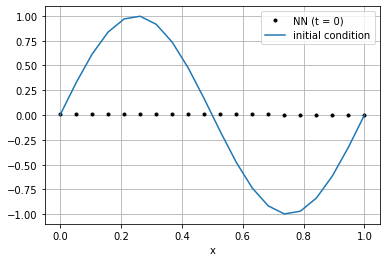

In [ ]:
# visualize initial condition
pde.evaluate({'x': x, 't': np.array([0])})
plt.plot(x, pde.outputs['p'], '.k', label="NN (t = 0)")
plt.plot(x, p0, label="initial condition")
plt.grid()
plt.xlabel('x')
plt.legend()
plt.show()

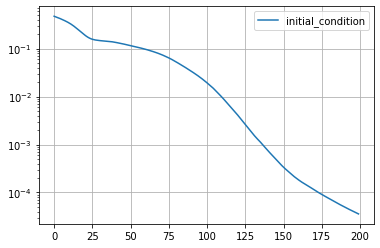

In [ ]:
# pre-train on boundary conditions
hist = pde.warm(epochs=200)

# you can pass a list of the bocos you want to pre-train on
#hist = pde.warm(epochs=200, bocos=['initial_condition'])

for h in hist:
    plt.plot(hist[h], label=h)
plt.legend()
plt.grid()
plt.yscale("log")
plt.show()

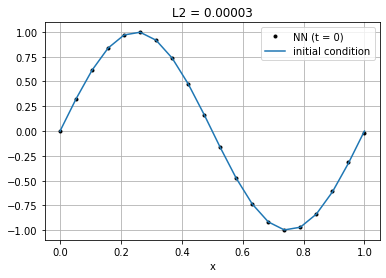

In [ ]:
# visualize initial condition
pde.evaluate({'x': x, 't': np.array([0])})
plt.plot(x, pde.outputs['p'], '.k' ,label="NN (t = 0)")
plt.plot(x, p0, label="initial condition")
plt.grid()
plt.xlabel('x')
plt.title(f"L2 = {np.mean((pde.outputs['p']-p0)**2):.5f}")
plt.legend()
plt.show()